In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from utils.calc_time import format_data
import sys
sys.path.append('../heuristic')
from methods.common import parse_env,ruler,calculate_cost,fitness
# 超参数
num_epochs = 1000
batch_size = 32
num_classes = 5
num_shots = 1 # 每个类别的样本数
num_tasks = 32 # 元学习任务数
lr_inner = 0.4 # 内部学习率
lr_outer = 0.1 # 外部学习率

In [2]:
def env2vec(path):
    Job_pd=pd.read_excel(path,sheet_name='Job info')
    Mac_pd=pd.read_excel(path,sheet_name='Machine info')
    Pr1_pd=pd.read_excel(path,sheet_name='Process 1 Time')
    Pr2_pd=pd.read_excel(path,sheet_name='Process 2 Time')
    # 定义问题的参数
    J = len(Job_pd)
    M = len(Mac_pd)
    W = Job_pd['准备时间'].mean()  # 订单的 Task0 和 Task1 之间的准备时间
    N = Job_pd['需求量'].values  # 订单的需求量
    A = Job_pd['到达时刻'].values  # 订单的到达时刻
    D = Job_pd['交货期'].values  # 订单的交货期
    pt= np.array([Pr1_pd[['Machine_0','Machine_1']].values,Pr2_pd[['Machine_0','Machine_1']].values])# 订单的 Task0 在生产线 i 上的单位处理时长 # 订单的 Task1 在生产线 i 上的单位处理时长
    p = np.array([Mac_pd[['闲置功率','工作功率']].values[:,0],Mac_pd[['闲置功率','工作功率']].values[:,1]])   # 生产线的闲置功率和工作功率
    rawdata=pd.concat([Job_pd,pd.DataFrame(N*p[1].mean(),columns=['预计功耗']),Pr1_pd[['Machine_0','Machine_1']],Pr2_pd[['Machine_0','Machine_1']]],axis=1).iloc[:,1:]
    rawdata=pd.concat([Job_pd,pd.DataFrame(N*p[1].mean(),columns=['预计功耗']),Pr1_pd[['Machine_0','Machine_1']],Pr2_pd[['Machine_0','Machine_1']]],axis=1).iloc[:,1:]
    column_length=len(rawdata.columns)
    rawdata=pd.concat([rawdata,rawdata.describe()])
    rawdata = rawdata.append(pd.Series(p.flatten().tolist()+[0] * (column_length-4), index=rawdata.columns), ignore_index=True)
    return rawdata.to_numpy()


In [3]:
import torch.nn.functional as F
class MLP(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, dropout=0.5):
        super(MLP, self).__init__()
        self.dropout = torch.nn.Dropout(dropout)

        self.hidden_1 = torch.nn.Linear(n_feature, n_hidden)  # hidden layer
        self.bn1 = torch.nn.BatchNorm1d(n_hidden)

        self.hidden_2 = torch.nn.Linear(n_hidden, n_hidden//2)
        self.bn2 = torch.nn.BatchNorm1d(n_hidden//2)

        self.hidden_3 = torch.nn.Linear(n_hidden//2, n_hidden//4)  # hidden layer
        self.bn3 = torch.nn.BatchNorm1d(n_hidden//4)

        self.hidden_4 = torch.nn.Linear(n_hidden // 4, n_hidden // 8)  # hidden layer
        self.bn4 = torch.nn.BatchNorm1d(n_hidden // 8)

        self.out = torch.nn.Linear(n_hidden//8, n_output)  # output layer

    def forward(self, x):
        x = F.relu(self.hidden_1(x))  # activation function for hidden layer
        x = self.dropout(self.bn1(x))
        x = F.relu(self.hidden_2(x))  # activation function for hidden layer
        x = self.dropout(self.bn2(x))
        x = F.relu(self.hidden_3(x))  # activation function for hidden layer
        x = self.dropout(self.bn3(x))
        x = F.relu(self.hidden_4(x))  # activation function for hidden layer
        x = self.dropout(self.bn4(x))
        x = self.out(x)
        return x

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils import data
import numpy as np
from utils import parse_opts
import warnings
warnings.filterwarnings("ignore")
def load_data(path):
    # 读取合并X和Y
    df = pd.read_csv(path)
    # df['feature'] = df.path.parallel_apply(lambda x:env2vec(x.replace('./','env/')).flatten().tolist())
    # df.to_feather('/home/linjw/iProject/HA-Prototypical/env/env2vec.feather')
    df = pd.read_feather('../env/env2vec.feather')
    return df

def process_data(df, mode, type = 'MAML'):
    if mode != 'test' and type != 'MLP':
        df = np.vstack((df.values, df.values))
    else:
        df = df.values
    x = np.array(df[:,-1])
    x = np.array([list(i) for i in x],dtype=np.float32)
    y = [np.array(eval(i)).flatten() for i in df[:,-3]]
    y = np.array([list(x) for x in y])
    y_index = np.arange(len(y)) % (len(y)/2 if mode != 'test' else len(y)/2)
    return x, y_index, {i: y[i] for i in range(len(y))}, y

# 定义MAML_Dataset类
class MAML_Dataset(data.Dataset):
    def __init__(self, mode, path, test_size=0.25, random_state=0):
        super().__init__()
        # self.sample_len = 1024
        self.df = load_data(path)
        self.train_df, self.test_df = train_test_split(self.df, test_size=test_size, random_state=random_state)
        self.x, self.y, self.label_dict, _ = process_data(self.train_df if mode != 'test' else self.test_df,mode)

    def __getitem__(self, index):
        x = np.array(self.x[index],dtype=np.float32)
        y = self.y[index]
        return x, y

    def __len__(self):
        return len(self.x)

In [5]:
dataset = MAML_Dataset('train',path='../env/bob_info.csv')

In [6]:
train_x = torch.from_numpy(np.array([list(x) for x in dataset.train_df['feature'].values])).float()
train_y = torch.from_numpy(np.array([list(eval(x)) for x in dataset.train_df['bob'].values]).reshape(-1,450)).float()
test_x = torch.from_numpy(np.array([list(x) for x in dataset.test_df['feature'].values])).float()
test_y = torch.from_numpy(np.array([list(eval(x)) for x in dataset.test_df['bob'].values]).reshape(-1,450)).float()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import metrics
from math import sqrt
input_size = 151  # 输入特征的维度
output_size = 151  # 输出特征的维度
learning_rate = 0.01  # 学习率

model=MLP(756, 256, 450)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 400  # 迭代次数
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    # 前向传播
    inputs = train_x
    labels = train_y
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        inputs = test_x
        labels = test_y
        predicted = model(inputs)
        loss_ = criterion(predicted, labels)
        train_losses.append(loss.item())
        test_losses.append(loss_.item())
        test_df=dataset.test_df
        test_df.index=range(len(test_df))
        predicted_time_list = []
        product_list=[ruler(x.reshape(150,3),75) for x in predicted.numpy()]
        for i, file_name in test_df.iterrows():
            excel_name = file_name['path'].replace('./','../env/')
            order = product_list[i]
            J, M, A, D, N, pt, p, W = parse_env(excel_name)
            predicted_time_list.append(-fitness(order, J, M, A, D, N, pt, p, W))
        predicted_time_list = format_data(predicted_time_list,0) #32 25 22
        # Convert the object results for the test dataset to a list
        true_time_list = test_df['fitness'].values.tolist()
        # Calculate the performance metrics
        error_list = []
        percent_error_list = []
        for i in range(len(true_time_list)):
            true_time_list[i] = float(true_time_list[i])
            predicted_time_list[i] = float(predicted_time_list[i])
            error_list.append(true_time_list[i] - predicted_time_list[i])
            percent_error_list.append((true_time_list[i] - predicted_time_list[i]) / true_time_list[i])
        rmse = sqrt(metrics.mean_squared_error(true_time_list, predicted_time_list))
        r2 = metrics.r2_score(true_time_list, predicted_time_list)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}, Test RMSE: {:.4f}, Test R2: {:.4f}'.format(epoch+1, num_epochs, loss.item(), loss_.item(),rmse,r2))
        if rmse<1900 :
            break

Epoch [1/400], Train Loss: 613.6035, Test Loss: 613.4882, Test RMSE: 2465.2354, Test R2: 0.9800


KeyboardInterrupt: 

### 评估部分

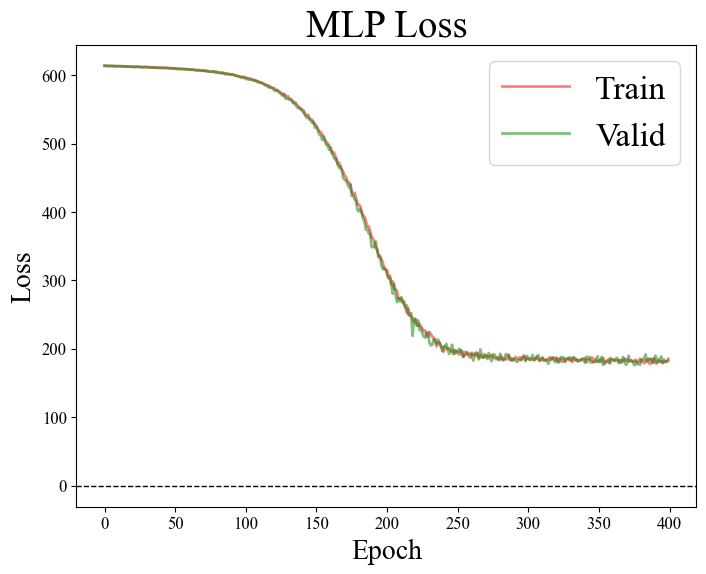

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')
# 生成随机数据
x = np.arange(0, 400)
y1 = train_losses
y2 = test_losses
# 计算移动平均值
window_size = 10
window = np.ones(window_size) / float(window_size)
y_smooth = np.convolve(y1, window, 'same')

# 绘图
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y1, alpha=0.5, color='red', linewidth=2, label='Train')
ax.plot(x, y2, alpha=0.5, color='green', linewidth=2, label='Valid')
# 界限线
ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
# 标题和标签
ax.set_title('MLP Loss', fontsize=28)
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)
# 图例
ax.legend(loc='best', fontsize=24)

plt.show()

In [15]:
predicted.detach().cpu().numpy()[0].shape

(450,)

In [20]:
predicted.detach().numpy()[0].reshape(150,3)

array([[-1.98356271e-01, -1.87823367e+00,  4.36148345e-01],
       [-2.25000262e+00, -3.06422567e+00, -7.48303309e-02],
       [ 3.00063819e-01,  1.32730734e+00,  1.25509858e+00],
       [-1.43195617e+00, -2.81056714e+00, -1.02137542e+00],
       [-2.23524714e+00, -9.37729239e-01,  2.39496708e+00],
       [ 1.72705340e+00,  7.59176850e-01, -6.70933962e-01],
       [ 2.16778731e+00,  1.57018280e+00, -4.98664379e-01],
       [-1.64866531e+00, -8.63104224e-01, -6.30352318e-01],
       [ 1.41826379e+00,  1.29972708e+00, -1.12926161e+00],
       [ 2.83591807e-01,  9.76021051e-01,  8.31788301e-01],
       [ 9.49210703e-01,  4.34791356e-01, -4.10955489e-01],
       [ 7.56136000e-01,  1.31143689e+00,  7.06216872e-01],
       [-4.48646784e-01,  1.28006279e+00,  1.86405337e+00],
       [ 8.98910642e-01,  8.02945137e-01,  4.58934665e-01],
       [ 4.28483963e-01,  9.74667192e-01,  1.45654589e-01],
       [ 3.75900716e-01,  2.65076637e-01, -1.69753814e+00],
       [-9.44215298e-01,  7.90643454e-01

In [10]:
product_list=[ruler(x.reshape(150,3),75) for x in predicted.numpy()]
product_list

[[[51, 0, 0],
  [9, 0, 0],
  [8, 1, 0],
  [8, 1, 1],
  [35, 1, 0],
  [12, 1, 0],
  [66, 0, 0],
  [1, 1, 0],
  [23, 0, 0],
  [10, 1, 0],
  [45, 0, 0],
  [10, 1, 1],
  [30, 1, 0],
  [4, 0, 0],
  [25, 0, 0],
  [20, 1, 0],
  [49, 0, 0],
  [26, 1, 0],
  [47, 1, 0],
  [15, 0, 0],
  [71, 0, 0],
  [3, 1, 0],
  [37, 0, 0],
  [13, 1, 0],
  [67, 0, 0],
  [19, 0, 0],
  [65, 1, 0],
  [12, 1, 1],
  [58, 0, 0],
  [38, 0, 0],
  [45, 0, 1],
  [22, 1, 0],
  [72, 1, 0],
  [6, 1, 0],
  [52, 1, 0],
  [64, 0, 0],
  [6, 1, 1],
  [1, 0, 1],
  [21, 0, 0],
  [19, 1, 1],
  [32, 1, 0],
  [28, 0, 0],
  [15, 1, 1],
  [7, 0, 0],
  [46, 0, 0],
  [44, 1, 0],
  [70, 0, 0],
  [2, 1, 0],
  [49, 0, 1],
  [48, 0, 0],
  [30, 0, 1],
  [0, 0, 0],
  [43, 0, 0],
  [14, 1, 0],
  [36, 0, 0],
  [57, 1, 0],
  [32, 0, 1],
  [5, 1, 0],
  [43, 0, 1],
  [29, 1, 0],
  [64, 0, 1],
  [34, 0, 0],
  [55, 0, 0],
  [63, 1, 0],
  [73, 1, 0],
  [67, 1, 1],
  [62, 1, 0],
  [61, 0, 0],
  [52, 1, 1],
  [24, 1, 0],
  [70, 0, 1],
  [61, 0, 1],
  [21

In [13]:
test_df=dataset.test_df
test_df.index=range(len(test_df))
predicted_time_list = []
for i, file_name in test_df.iterrows():
    excel_name = file_name['path'].replace('./','../env/')
    order = product_list[i]
    J, M, A, D, N, pt, p, W = parse_env(excel_name)
    predicted_time_list.append(-fitness(order, J, M, A, D, N, pt, p, W))
predicted_time_list = format_data(predicted_time_list,0) #32 25 22
# Convert the object results for the test dataset to a list
true_time_list = test_df['fitness'].values.tolist()
# Calculate the performance metrics
error_list = []
percent_error_list = []
for i in range(len(true_time_list)):
    true_time_list[i] = float(true_time_list[i])
    predicted_time_list[i] = float(predicted_time_list[i])
    error_list.append(true_time_list[i] - predicted_time_list[i])
    percent_error_list.append((true_time_list[i] - predicted_time_list[i]) / true_time_list[i])
pd.DataFrame([true_time_list,predicted_time_list],index=['Predict','GroundTruth']).T.to_csv('./compare/MLP_label.csv',index=False) 
pd.DataFrame([true_time_list,predicted_time_list],index=['Predict','GroundTruth']).T    

,Predict,GroundTruth
0,14252.853,12606.010468
1,62381.997,63413.277890
2,59972.889,57185.865034
3,16997.133,17053.956482
4,32224.176,33824.177764
...,...,...
95,13090.455,13363.591575
96,12261.792,11982.893748
97,55773.762,59057.220819
98,30945.003,28461.030853


In [44]:
# Calculate the performance metrics
error_list = []
percent_error_list = []
for i in range(len(true_time_list)):
    true_time_list[i] = float(true_time_list[i])
    predicted_time_list[i] = float(predicted_time_list[i])
    error_list.append(true_time_list[i] - predicted_time_list[i])
    percent_error_list.append((true_time_list[i] - predicted_time_list[i]) / true_time_list[i])

# Create a dataframe with the performance metrics and write it to an Excel file
performance_df = pd.DataFrame(columns=['average error', 'average percent error', 'predicted time average', 'predicted time max', 'predicted time min'])
performance_df.loc[0] = [sum(error_list)/len(error_list), sum(percent_error_list)/len(percent_error_list), sum(predicted_time_list)/len(predicted_time_list), max(predicted_time_list), min(predicted_time_list)]

In [46]:
pd.DataFrame([true_time_list,predicted_time_list],index=['Predict','GroundTruth']).T.to_csv('./compare/MLP_label.csv',index=False) 
pd.DataFrame([true_time_list,predicted_time_list],index=['Predict','GroundTruth']).T

,Predict,GroundTruth
0,14252.853,13068.520613
1,62381.997,60652.237388
2,59972.889,59696.460173
3,16997.133,15237.594396
4,32224.176,34301.464257
...,...,...
95,13090.455,13278.894799
96,12261.792,11573.529925
97,55773.762,59684.687320
98,30945.003,30582.400463


In [48]:
from sklearn import metrics
from math import sqrt
sqrt(metrics.mean_squared_error(true_time_list, predicted_time_list))

2207.636135462992

In [17]:
performance_df

,average error,average percent error,predicted time average,predicted time max,predicted time min
0,-6603.737638,-0.19484,39208.927663,93395.118128,14427.595761
